loss is [3.7625582  0.01068887 3.773247  ]
loss is [0.7899217  0.00162801 0.79154974]
loss is [5.6366938e-01 3.8713879e-06 5.6367326e-01]
loss is [4.7584888e-01 5.0131253e-05 4.7589901e-01]
loss is [4.0163961e-01 9.0477535e-08 4.0163970e-01]
loss is [8.1481721e-04 1.4122175e-08 8.1483135e-04]
loss is [3.4124960e-06 3.0438999e-11 3.4125264e-06]
loss is [1.3093833e-06 8.6944466e-11 1.3094702e-06]
loss is [5.8750948e-07 3.2105443e-11 5.8754159e-07]
loss is [2.9475495e-07 1.2314649e-11 2.9476726e-07]
loss is [4.0878025e-05 2.9756100e-06 4.3853634e-05]
loss is [7.0090465e-07 4.2890191e-11 7.0094757e-07]
loss is [2.3972675e-07 8.6830682e-12 2.3973544e-07]
loss is [9.9816702e-08 1.3684179e-11 9.9830388e-08]
loss is [5.8331026e-04 2.4134840e-06 5.8572373e-04]
loss is [3.2051583e-05 3.8279801e-08 3.2089862e-05]
loss is [4.107290e-06 3.171516e-08 4.139005e-06]
loss is [1.9675074e-04 3.4259249e-06 2.0017667e-04]
loss is [1.7721322e-05 1.9390939e-06 1.9660416e-05]
loss is [3.1943338e-05 1.3251680e

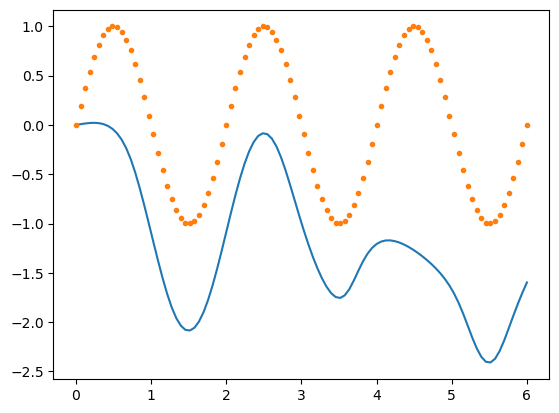

In [1]:
import sys
sys.path.append('../../')

import numpy as np
import torch
import matplotlib

from user_funn.field import D1Field
from user_funn.get_net import ForwardNetwork
from user_funn.ds import get_data_loader
from user_funn.solver import CloudPointSolver
from user_funn.pde import grad

# 保证迭代参数与DEEPXDE一致
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ForwardNetwork([1, 50, 50, 50, 1]).to(device)
loss_fn = torch.nn.MSELoss()

t_length = 6

## define a pde
pde_epoch_size = 16
pde_batch_num = 1
pde_batch_size = pde_epoch_size//pde_batch_num
pde_input = D1Field([0,t_length]).get_field_rand(pde_epoch_size)
pde_output = np.zeros([pde_epoch_size,1])

def pde_loss(model, data):
    x_in,y_real = data
    x_in.requires_grad=True
    U = model(x_in)
    u = U[:,[0]]
    dudx = grad(u, x_in)[0]
    loss = dudx - torch.pi * torch.cos(torch.pi * x_in)
    loss = loss_fn(loss, y_real)
    return loss

## define a bc
bc_epoch_size = 1
bc_batch_num = 1
bc_batch_size = bc_epoch_size//bc_batch_num
bc_input = np.array([[0]])
bc_output = np.zeros([bc_epoch_size ,1])
bc_batch_size = bc_epoch_size

from user_funn.bc import data_loss_factory
data_loss = data_loss_factory(loss_fn,[0])

solver = CloudPointSolver(
    [[pde_input, pde_output],[bc_input, bc_output]],
    [pde_loss,data_loss],
    model = [1, 100, 100, 100, 1],
    optimizer = "adam",
    batchsize = [pde_batch_size,bc_batch_size])

epoch_num = 3000
for i in range(epoch_num):
    solver.train_step()
    if i%100 == 0:
        solver.test_step(print_flag=True)

x_cpu = np.linspace(0,t_length,100).reshape(100,1)
y_cpu = solver.model_eval(x_cpu)


total error 1.2064569189026952


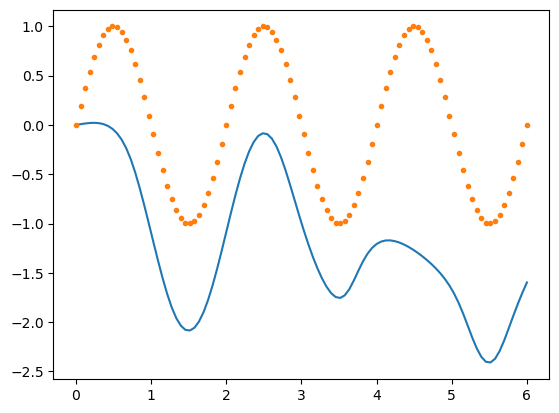

In [2]:

import matplotlib.pyplot as plt
fig,ax = plt.subplots()
ax.plot(x_cpu,y_cpu)
ax.plot(x_cpu,np.sin(np.pi*x_cpu),'.')

y_all_real = np.sin(np.pi*np.array(x_cpu))
print('total error', np.mean(np.abs(np.array(y_all_real)-np.array(y_cpu))) )